In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
from IPython.display import clear_output


## **Deep Dream**

DeepDream is a computer vision program created by Google engineers that uses a convolutional neural network to find and enhance patterns in images via algorithmic pareidolia, thus creating a dream-like hallucinogenic appearance in the deliberately over-processed images. DeepDream over-interprets and enhances the patterns it sees in an image, allowing us to visualize what Convnets learn. 

We simply feed the network an arbitrary image or photo and let the network analyze the picture. We then pick a layer and ask the network to enhance whatever it detected. This is done by calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. 

Each layer of the network deals with features at a different level of abstraction, so the complexity of features we generate depends on which layer we choose to enhance. For example, lower layers tend to produce strokes or simple ornament-like patterns, because those layers are sensitive to basic features such as edges and their orientations.

If we choose higher-level layers, which identify more sophisticated features in images, complex features or even whole objects tend to emerge. Again, we just start with an existing image and give it to our neural net. We ask the network: “Whatever you see there, I want more of it!” This creates a feedback loop: if a cloud looks a little bit like a bird, the network will make it look more like a bird. This in turn will make the network recognize the bird even more strongly on the next pass and so forth, until a highly detailed bird appears, seemingly out of nowhere.



# **1. Preprocessing and model loading**

In [ ]:
def load_image_to_array(url, target_size) : 
  name = url.split('/')[-1]
  path = tf.keras.utils.get_file(name, origin = url)
  img = tf.keras.preprocessing.image.load_img(path, target_size = target_size)
  img = tf.keras.preprocessing.image.img_to_array(img, dtype='uint8') 
  return img

def show(img, figsize):
  plt.figure(figsize=figsize)
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

In [ ]:
def preprocess(img):
  """ Convert RGB values from [0, 255] to [0, 1] """ 
  img = tf.cast(img, tf.float32)
  img = img/255.
  return img


def unprocess(img) : 
   """ Undo the preprocessing above """
  img = img*255
  img = tf.cast(img, tf.uint8)
  return img


def preprocess2(img):
  """ Convert RGB values from [0, 255] to [-1, 1] """
  img = tf.cast(img, tf.float32)
  img /= 128.0
  img -= 1.
  return img

def unprocess2(img):
  """ Undo the preprocessing above """
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)

#### **Load pre-trained model**

The loaded model is InceptionV3 ([Wikipedia page](https://en.wikipedia.org/wiki/Inceptionv3)), trained on Imagenet.


In [ ]:
conv_base = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False)

In [ ]:
conv_base.summary()

# **2. Prepare feature extraction model and DeepDream**

In [ ]:
# choose layers for which we want to maximize the activations 
names = ['mixed2', 'mixed3', 'mixed4', 'mixed5'] # mixed corresponds to 'concatenate' layers
layers = [conv_base.get_layer(name).output for name in names]

# create a model to extract the outputs of these layers
extraction_model = tf.keras.Model(inputs=conv_base.input, outputs=layers)

In [ ]:
# compute the loss 
def compute_loss(img): 
  batch = tf.expand_dims(img, 0)
  layer_activations = extraction_model(batch)
  losses = [tf.reduce_mean(act) for act in layer_activations]
  return tf.reduce_sum(losses)

 # gradient ascent step
@tf.function 
def gd_step(img, learning_rate):
  with tf.GradientTape() as tape :
    loss = compute_loss(img)
  gradients = tape.gradient(loss, img)
  gradients = gradients/(tf.math.reduce_std(gradients + 1e-8))

  img.assign_add(learning_rate*gradients)
  img.assign(tf.clip_by_value(img, -1, 1))



epochs = 1000
learning_rate = 0.001

def deepdream(image, epochs, learning_rate):

  for i in range(epochs) :
    gd_step(image, learning_rate)
    if i%50 == 0 :
      print(i)
    if i%200 == 0 :
      clear_output(wait = True)
      print(f'step{i}')
      show(unprocess(image.numpy()), (8,8))

  clear_output(wait = True)
  show(unprocess(image.numpy()), (16,16))

# **3. Test it on a cloud image**

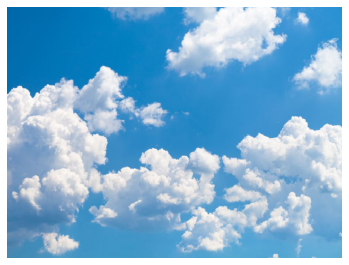

In [ ]:
url2 = 'https://storage.googleapis.com/gjmbucket1/nuages.jpg'
original_image_2 = load_image_to_array(url2, (600,800))
show(original_image_2, (6,6))

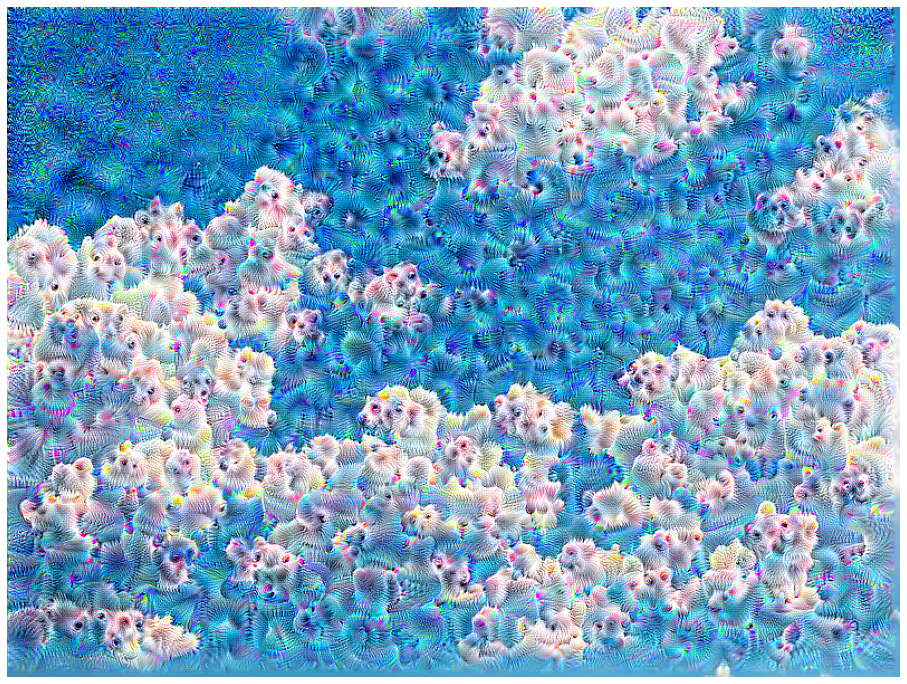

In [ ]:
image_2 = tf.Variable(preprocess(original_image_2))
deepdream(image_2, epochs, learning_rate = 2*learning_rate)

# **4. Maximize activations on more layers**

In [ ]:
url3 = 'https://storage.googleapis.com/gjmbucket1/vaches.jpg'
original_image_3 = load_image_to_array(url3, (500,1000))

# new extraction model 
# choose layers for which we want to maximize the activations 
names_2 = ['mixed2', 'mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7'] # mixed corresponds to 'concatenate' layers
layers_2 = [conv_base.get_layer(name).output for name in names_2]

# create a model to extract the outputs of these layers
extraction_model_2 = tf.keras.Model(inputs=conv_base.input, outputs=layers_2)

def compute_loss_2(img): 
  batch = tf.expand_dims(img, 0)
  layer_activations = extraction_model_2(batch)
  losses = [tf.reduce_mean(act) for act in layer_activations]
  return tf.reduce_sum(losses)

# gradient ascent step
def gd_step_2(img, learning_rate):
  with tf.GradientTape() as tape :
    loss = compute_loss(img)
  gradients = tape.gradient(loss, img)
  #gradients = gradients/(tf.math.reduce_std(gradients + 1e-8))

  img.assign_add(learning_rate*gradients)
  img.assign(tf.clip_by_value(img, -1, 1))


def deepdream_2(image, epochs, learning_rate):

  for i in range(epochs) :
    gd_step_2(image, learning_rate)
    if i%50 == 0 :
      print(i)
    if i%200 == 0 :
      clear_output(wait = True)
      print(f'step{i}')
      show(unprocess(image.numpy()), (8,8))

  clear_output(wait = True)
  show(unprocess(image.numpy()), (22,10))
  return unprocess(image.numpy())




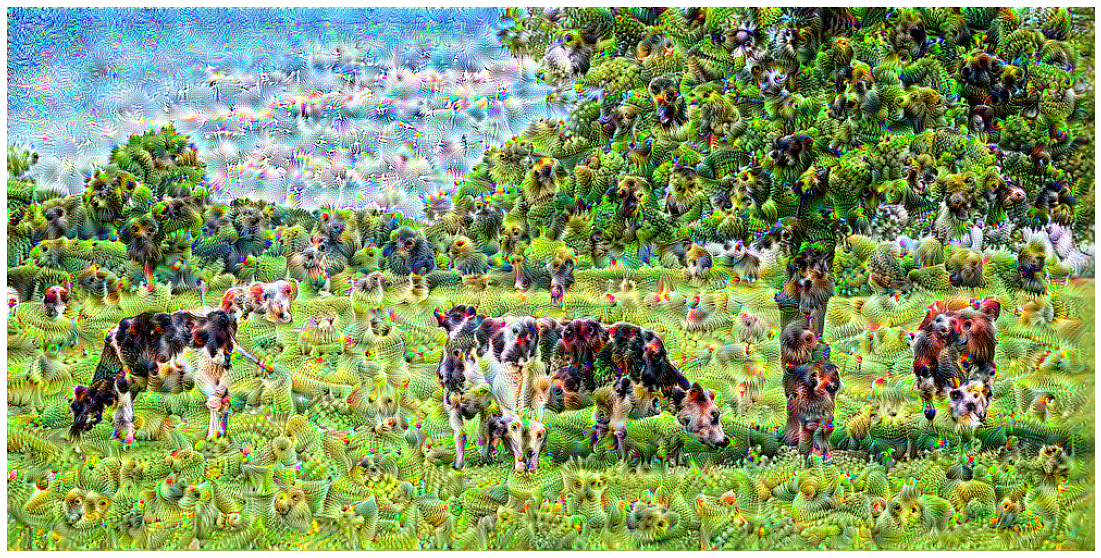

In [ ]:
image_3 = tf.Variable(preprocess(original_image_3))
vaches_2 = deepdream_2(image_3, epochs, 2*learning_rate)

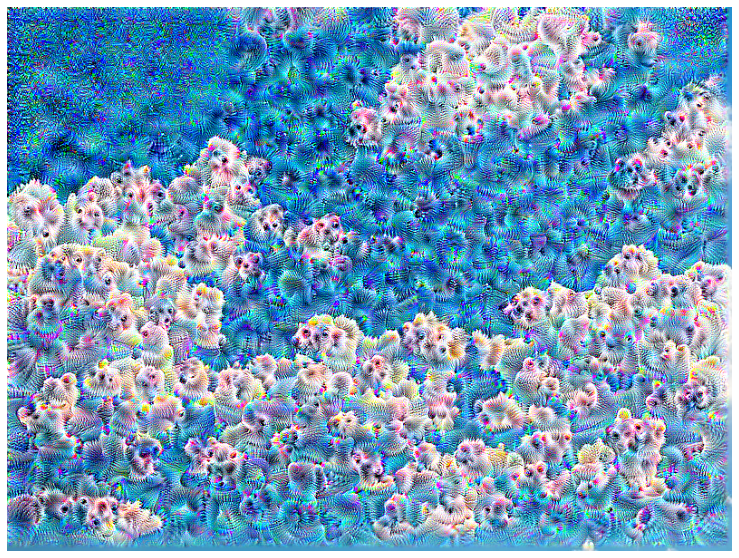

In [ ]:
nuages_ = deepdream_2(image_2, epochs, learning_rate)